In [1]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

# Others
import shutil
import random

In [4]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/potato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 185M/185M [00:03<00:00, 55.7MB/s]


In [5]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato/Potato/train",
    label_mode="categorical",
    class_names= ['Potato healthy', 'Potato leaf early blight', 'Potato leaf late blight'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato/Potato/valid",
    label_mode="categorical",
    class_names= ['Potato healthy', 'Potato leaf early blight', 'Potato leaf late blight'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 5907 files belonging to 3 classes.
==========================Validation Data====================
Found 1442 files belonging to 3 classes.


In [6]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("potato/Potato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("potato/Potato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))


Found 5907 images belonging to 3 classes.
Found 1442 images belonging to 3 classes.


In [7]:
# Check GPU
!nvidia-smi

Sun Jun  4 13:13:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P0    26W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

In [10]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Potato_MobileNetV2_model1_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [11]:
# Define DIY Model
MobileNetV2_model = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(3, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_max_pooling2d (Globa  (None, 1280)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                           

In [12]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_1 = MobileNetV2_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.3805 - accuracy: 0.9255
Epoch 1: val_accuracy improved from -inf to 0.32178, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 100s 201ms/step - loss: 0.3805 - accuracy: 0.9255 - val_loss: 11.5834 - val_accuracy: 0.3218 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9626
Epoch 2: val_accuracy did not improve from 0.32178
296/296 [==============================] - 34s 114ms/step - loss: 0.1076 - accuracy: 0.9626 - val_loss: 9.0264 - val_accuracy: 0.3162 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.9567
Epoch 3: val_accuracy improved from 0.32178 to 0.49029, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 58s 195ms/step - loss: 0.1311 - accuracy: 0.9567 - val_loss: 1.3434 - val_accuracy: 0.4903 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9702
Epoch 4: val_accuracy improved from 0.49029 to 0.77184, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 57s 194ms/step - loss: 0.0723 - accuracy: 0.9702 - val_loss: 0.6120 - val_accuracy: 0.7718 - lr: 0.0010
Epoch 5/100
296/296 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9761
Epoch 5: val_accuracy did not improve from 0.77184
296/296 [==============================] - 34s 114ms/step - loss: 0.0555 - accuracy: 0.9761 - val_loss: 3.5435 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - ETA: 0s - loss: 0.0635 - accuracy: 0.9773
Epoch 6: val_accuracy improved from 0.77184 to 0.87171, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 58s 196ms/step - loss: 0.0635 - accuracy: 0.9773 - val_loss: 0.4993 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 7/100
296/296 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9832
Epoch 7: val_accuracy improved from 0.87171 to 0.91609, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 57s 194ms/step - loss: 0.0379 - accuracy: 0.9832 - val_loss: 0.4972 - val_accuracy: 0.9161 - lr: 0.0010
Epoch 8/100
296/296 [==============================] - ETA: 0s - loss: 0.0452 - accuracy: 0.9788
Epoch 8: val_accuracy did not improve from 0.91609
296/296 [==============================] - 34s 115ms/step - loss: 0.0452 - accuracy: 0.9788 - val_loss: 0.6955 - val_accuracy: 0.7691 - lr: 0.0010
Epoch 9/100
296/296 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9753
Epoch 9: val_accuracy did not improve from 0.91609
296/296 [==============================] - 34s 114ms/step - loss: 0.0777 - accuracy: 0.9753 - val_loss: 0.9926 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 10/100
296/296 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9805
Epoch 10: val_accuracy did not improve from 0.91609
296/296 [==============================] - 35s 117ms/step - loss: 0.0521 - accuracy: 0.9805 - val_loss: 1.2379 - 

296/296 [==============================] - 59s 199ms/step - loss: 0.0692 - accuracy: 0.9761 - val_loss: 0.2604 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 12/100
296/296 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9785
Epoch 12: val_accuracy did not improve from 0.94938
296/296 [==============================] - 34s 116ms/step - loss: 0.0514 - accuracy: 0.9785 - val_loss: 0.3025 - val_accuracy: 0.9036 - lr: 0.0010
Epoch 13/100
296/296 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9831
Epoch 13: val_accuracy did not improve from 0.94938
296/296 [==============================] - 33s 112ms/step - loss: 0.0401 - accuracy: 0.9831 - val_loss: 0.2969 - val_accuracy: 0.9126 - lr: 0.0010
Epoch 14/100
296/296 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9814
Epoch 14: val_accuracy did not improve from 0.94938
296/296 [==============================] - 34s 113ms/step - loss: 0.0447 - accuracy: 0.9814 - val_loss: 4.450

296/296 [==============================] - 58s 198ms/step - loss: 0.0242 - accuracy: 0.9888 - val_loss: 0.0607 - val_accuracy: 0.9806 - lr: 1.0000e-04
Epoch 19/100
296/296 [==============================] - ETA: 0s - loss: 0.0210 - accuracy: 0.9898
Epoch 19: val_accuracy improved from 0.98058 to 0.98960, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 58s 195ms/step - loss: 0.0210 - accuracy: 0.9898 - val_loss: 0.0415 - val_accuracy: 0.9896 - lr: 1.0000e-04
Epoch 20/100
296/296 [==============================] - ETA: 0s - loss: 0.0209 - accuracy: 0.9915
Epoch 20: val_accuracy improved from 0.98960 to 0.99376, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 58s 196ms/step - loss: 0.0209 - accuracy: 0.9915 - val_loss: 0.0204 - val_accuracy: 0.9938 - lr: 1.0000e-04
Epoch 21/100
296/296 [==============================] - ETA: 0s - loss: 0.0171 - accuracy: 0.9920
Epoch 21: val_accuracy did not improve from 0.99376
296/296 [==============================] - 34s 114ms/step - loss: 0.0171 - accuracy: 0.9920 - val_loss: 0.0216 - val_accuracy: 0.9931 - lr: 1.0000e-04
Epoch 22/100
296/296 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9929
Epoch 22: val_accuracy improved from 0.99376 to 0.99515, saving model to Potato_MobileNetV2_model1_Based_Non_Augmented


296/296 [==============================] - 57s 193ms/step - loss: 0.0140 - accuracy: 0.9929 - val_loss: 0.0162 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 23/100
296/296 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.9944
Epoch 23: val_accuracy did not improve from 0.99515
296/296 [==============================] - 34s 114ms/step - loss: 0.0120 - accuracy: 0.9944 - val_loss: 0.0147 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 24/100
296/296 [==============================] - ETA: 0s - loss: 0.0176 - accuracy: 0.9942
Epoch 24: val_accuracy did not improve from 0.99515
296/296 [==============================] - 34s 114ms/step - loss: 0.0176 - accuracy: 0.9942 - val_loss: 0.0206 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 25/100
296/296 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.9954
Epoch 25: val_accuracy did not improve from 0.99515
296/296 [==============================] - 33s 111ms/step - loss: 0.0131 - accuracy: 0.9954 - val

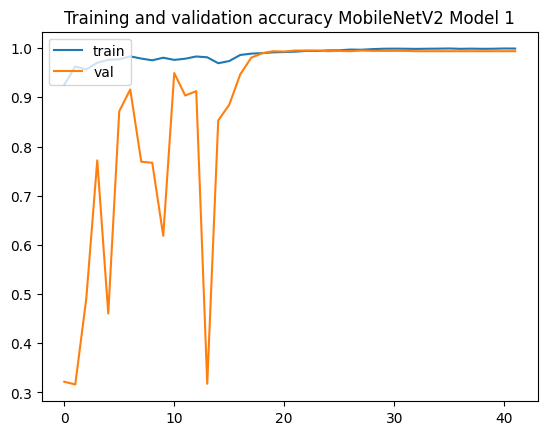

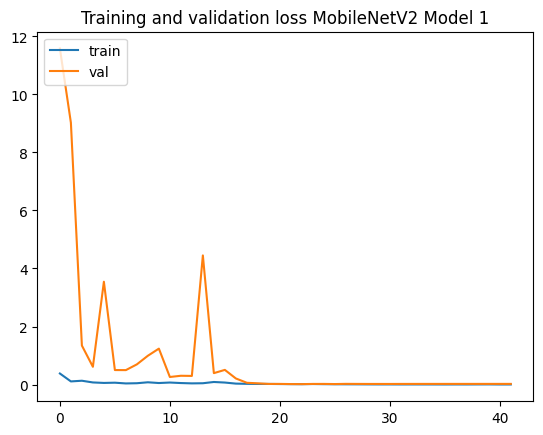

In [13]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_1.history['accuracy' ]
val_acc  = history_MobileNetV2_model_1.history['val_accuracy' ]
loss     = history_MobileNetV2_model_1.history['loss' ]
val_loss = history_MobileNetV2_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 1')
plt.legend(['train', 'val'], loc='upper left')

In [14]:
!zip -r /content/Potato_MobileNetV2_model1_Based_Non_Augmented.zip /content/Potato_MobileNetV2_model1_Based_Non_Augmented

  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/ (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/variables/variables.index (deflated 76%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Potato_MobileNetV2_model1_Based_Non_Augmented/saved_model.pb (deflated 91%)


In [15]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Potato_MobileNetV2_model2_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [16]:
# Define DIY Model
MobileNetV2_model_2 = tf.keras.models.Sequential([
    # MobileNetV2 Layer
    MobileNetV2(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(3, activation='softmax') 
  ])


# Compile Model
MobileNetV2_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
MobileNetV2_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               327936    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 2,586,691
Trainable params: 2,552,579
No

In [17]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_MobileNetV2_model_2 = MobileNetV2_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.1872 - accuracy: 0.9380
Epoch 1: val_accuracy improved from -inf to 0.31623, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 88s 203ms/step - loss: 0.1872 - accuracy: 0.9380 - val_loss: 25.2440 - val_accuracy: 0.3162 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.0841 - accuracy: 0.9689
Epoch 2: val_accuracy improved from 0.31623 to 0.50069, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 60s 201ms/step - loss: 0.0841 - accuracy: 0.9689 - val_loss: 4.4233 - val_accuracy: 0.5007 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.9717
Epoch 3: val_accuracy improved from 0.50069 to 0.50624, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 59s 199ms/step - loss: 0.0799 - accuracy: 0.9717 - val_loss: 7.5091 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - ETA: 0s - loss: 0.0913 - accuracy: 0.9675
Epoch 4: val_accuracy improved from 0.50624 to 0.84258, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 59s 201ms/step - loss: 0.0913 - accuracy: 0.9675 - val_loss: 1.7251 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 5/100
296/296 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9792
Epoch 5: val_accuracy improved from 0.84258 to 0.86338, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 58s 194ms/step - loss: 0.0539 - accuracy: 0.9792 - val_loss: 1.0548 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9792
Epoch 6: val_accuracy did not improve from 0.86338
296/296 [==============================] - 34s 114ms/step - loss: 0.0532 - accuracy: 0.9792 - val_loss: 1.8859 - val_accuracy: 0.7053 - lr: 0.0010
Epoch 7/100
296/296 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9793
Epoch 7: val_accuracy improved from 0.86338 to 0.91123, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 58s 197ms/step - loss: 0.0547 - accuracy: 0.9793 - val_loss: 0.5705 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 8/100
296/296 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9815
Epoch 8: val_accuracy did not improve from 0.91123
296/296 [==============================] - 35s 116ms/step - loss: 0.0484 - accuracy: 0.9815 - val_loss: 0.4106 - val_accuracy: 0.8890 - lr: 0.0010
Epoch 9/100
296/296 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9802
Epoch 9: val_accuracy improved from 0.91123 to 0.97365, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 57s 194ms/step - loss: 0.0466 - accuracy: 0.9802 - val_loss: 0.1305 - val_accuracy: 0.9736 - lr: 0.0010
Epoch 10/100
296/296 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9839
Epoch 10: val_accuracy did not improve from 0.97365
296/296 [==============================] - 34s 114ms/step - loss: 0.0401 - accuracy: 0.9839 - val_loss: 4.5255 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 11/100
296/296 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9746
Epoch 11: val_accuracy did not improve from 0.97365
296/296 [==============================] - 34s 114ms/step - loss: 0.0656 - accuracy: 0.9746 - val_loss: 0.8049 - val_accuracy: 0.8974 - lr: 0.0010
Epoch 12/100
296/296 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9839
Epoch 12: val_accuracy improved from 0.97365 to 0.98336, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 58s 197ms/step - loss: 0.0371 - accuracy: 0.9839 - val_loss: 0.1166 - val_accuracy: 0.9834 - lr: 0.0010
Epoch 13/100
296/296 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9849
Epoch 13: val_accuracy did not improve from 0.98336
296/296 [==============================] - 34s 116ms/step - loss: 0.0302 - accuracy: 0.9849 - val_loss: 5.7468 - val_accuracy: 0.5270 - lr: 0.0010
Epoch 14/100
296/296 [==============================] - ETA: 0s - loss: 0.0471 - accuracy: 0.9861
Epoch 14: val_accuracy did not improve from 0.98336
296/296 [==============================] - 34s 114ms/step - loss: 0.0471 - accuracy: 0.9861 - val_loss: 1.0632 - val_accuracy: 0.8377 - lr: 0.0010
Epoch 15/100
296/296 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9856
Epoch 15: val_accuracy did not improve from 0.98336
296/296 [==============================] - 33s 112ms/step - loss: 0.0342 - accuracy: 0.9856 - val_loss: 1.422

296/296 [==============================] - 58s 196ms/step - loss: 0.0185 - accuracy: 0.9924 - val_loss: 0.0578 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 25/100
296/296 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9926
Epoch 25: val_accuracy improved from 0.98752 to 0.99168, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 59s 201ms/step - loss: 0.0146 - accuracy: 0.9926 - val_loss: 0.0386 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 26/100
296/296 [==============================] - ETA: 0s - loss: 0.0151 - accuracy: 0.9937
Epoch 26: val_accuracy improved from 0.99168 to 0.99445, saving model to Potato_MobileNetV2_model2_Based_Non_Augmented


296/296 [==============================] - 59s 198ms/step - loss: 0.0151 - accuracy: 0.9937 - val_loss: 0.0265 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 27/100
296/296 [==============================] - ETA: 0s - loss: 0.0144 - accuracy: 0.9936
Epoch 27: val_accuracy did not improve from 0.99445
296/296 [==============================] - 34s 114ms/step - loss: 0.0144 - accuracy: 0.9936 - val_loss: 0.0258 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 28/100
296/296 [==============================] - ETA: 0s - loss: 0.0108 - accuracy: 0.9953
Epoch 28: val_accuracy did not improve from 0.99445
296/296 [==============================] - 33s 113ms/step - loss: 0.0108 - accuracy: 0.9953 - val_loss: 0.0258 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 29/100
296/296 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9959
Epoch 29: val_accuracy did not improve from 0.99445
296/296 [==============================] - 34s 115ms/step - loss: 0.0095 - accuracy: 0.9959 - val

296/296 [==============================] - 58s 196ms/step - loss: 0.0063 - accuracy: 0.9975 - val_loss: 0.0319 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 32/100
296/296 [==============================] - ETA: 0s - loss: 0.0062 - accuracy: 0.9973
Epoch 32: val_accuracy did not improve from 0.99515

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
296/296 [==============================] - 34s 115ms/step - loss: 0.0062 - accuracy: 0.9973 - val_loss: 0.0304 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 33/100
296/296 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9983
Epoch 33: val_accuracy did not improve from 0.99515
296/296 [==============================] - 34s 114ms/step - loss: 0.0052 - accuracy: 0.9983 - val_loss: 0.0310 - val_accuracy: 0.9945 - lr: 1.0000e-05
Epoch 34/100
296/296 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9990
Epoch 34: val_accuracy did not improve from 0.99515
296/296 [=========

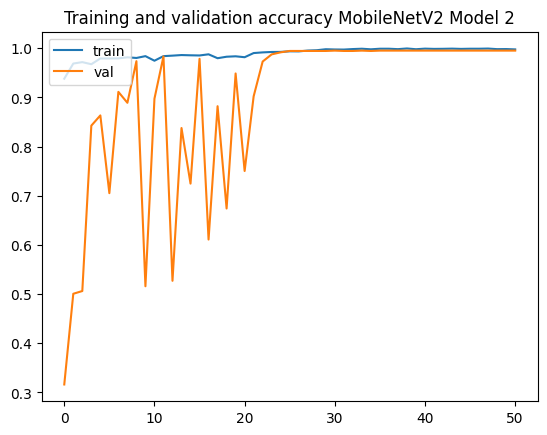

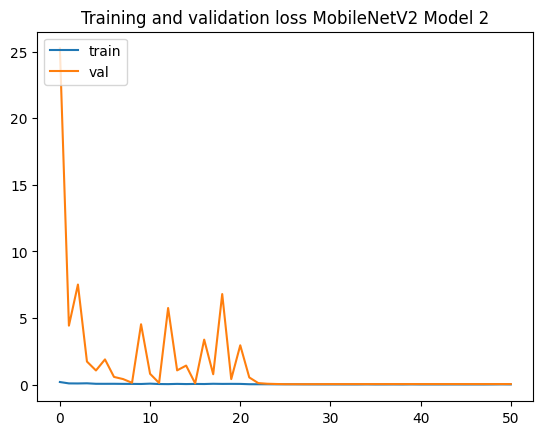

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_MobileNetV2_model_2.history['accuracy' ]
val_acc  = history_MobileNetV2_model_2.history['val_accuracy' ]
loss     = history_MobileNetV2_model_2.history['loss' ]
val_loss = history_MobileNetV2_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss MobileNetV2 Model 2')
plt.legend(['train', 'val'], loc='upper left')

In [20]:
!zip -r /content/Potato_MobileNetV2_model2_Based_Non_Augmented.zip /content/Potato_MobileNetV2_model2_Based_Non_Augmented

  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/ (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/variables/variables.index (deflated 76%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Potato_MobileNetV2_model2_Based_Non_Augmented/saved_model.pb (deflated 91%)
